In [28]:
from os.path import dirname, abspath
from os.path import join
import PIL
from PIL.Image import open, new, fromarray
from PIL.ImageOps import expand
from matplotlib.pyplot import savefig, imshow, set_cmap
import matplotlib.pyplot as plt
import numpy as np

from numpy import linalg as LA
from tqdm.notebook import tqdm

import torchvision
import sys

import torch
from torch.autograd import Variable
import os

from include import helper

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs", torch.cuda.device_count())
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

torch.set_printoptions(precision=4)

num GPUs 1


In [29]:
eps = np.spacing(1)
eps

2.220446049250313e-16

In [30]:
def np_to_tensor(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)

def np_to_var(img_np, dtype = torch.cuda.FloatTensor):
    '''Converts image in numpy.array to torch.Variable.
    
    From C x W x H [0..1] to  1 x C x W x H [0..1]
    '''
    return Variable(np_to_tensor(img_np)[None, :])

def var_to_np(img_var):
    '''Converts an image in torch.Variable format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.data.cpu().numpy()[0]

In [31]:
def betadiv(A,B,beta):
    """
    beta-divergence
    
        d = betadiv(A,B,beta)
    -a \= 0,1
     d(x|y) = ( x^a + (a-1)*y^a - a*x*y^(a-1) / (a*(a-1)) 
    -a = 1
     d(x|y) = x(log(x) - log(y)) + (y-x) KULLBACK-LEIBLER
    -a = 0
     d(x|y) = x/y - log(x/y) - 1         ITAKURA-SAITO
    """
    if beta == 2:
        d = torch.sum((A-B)**2)
    elif beta == 1:
        eps = np.spacing(1)
        d = torch.sum( A[A>eps] * torch.log(A[A>eps]/(B[A>eps] + eps)) - A[A>eps] + B[A>eps] ) + torch.sum(B[A<=eps])
    elif beta == 0:
        d = torch.sum( A/B - torch.log(A/B) ) - A.size
    else:
        d = torch.sum( A**beta + (beta-1)*B**beta - beta*(A * B**(beta-1)) ) / (beta*(beta-1))
    
    return d

In [32]:
def A_NMF(V,D,W,H,beta,l_r):
    """
    Perform AT-NMF
    
    Return the loss, RMSE on the test entries, basis and activation matrices, and adversary R. 
    
    :param V: The original data matrix. 
    :param D: The binary mask
    :param l_r: lambda
    :param beta: use beta = 2
    """

    
    maxout = 100
    maxin = 1000
    cost1 = np.zeros(maxout+1) # betadiv(V, WH)
    
    tol = 1e-2
    
    # Initialize W and H to get meaningful R
    
    for k in range(5):

        W = W * ((D*V)@H.T) / (W@(H@H.T) + eps)
        H = H * (W.T@(D*V)) / ((W.T@W)@H + eps)
    
    cost1[0] =  betadiv(D*V, D*(W@H), beta)
    print('Current iteration 0 and cost is %.3f\n' %(cost1[0]))
    
      
    # Start Adversarial Training
    iterator = tqdm(range(maxout))
    for k in iterator:
        
        # Update R
        R = torch.max( (D*V - D*(W@H))/(l_r-1), -D*V )
        new_V = D*(V+R)
        
        cost_in = np.zeros(maxin)
        cost_in[0] = betadiv(new_V, D*(W@H),beta)

        V_pre = W@H
        
        for i in range(1,maxin):
            V_ap_old = W@H
            
            W = W * (new_V@H.T) / (W@(H@H.T) + eps)
            H = H * (W.T@new_V) / ((W.T@W)@H + eps)
            
            V_ap_new = W@H
            
            cost_in[i] = betadiv(new_V, D*(W@H), beta)
            

            stp = (V_ap_old - V_ap_new) / V_ap_old
            stp[stp != stp] = 0
            if torch.norm(stp, 'fro') < tol:
                print('Reach inner stopping criterion at out %d and in %d' %(k, i))
                break 
        
        cost1[k+1] = betadiv(D*V, D*(W@H), beta)
        
        
        
        V_cur = W@H
        
        stp1 = (V_pre - V_cur) / V_pre
        stp1[stp1 != stp1] = 0
        if torch.norm(stp1, 'fro') < tol:
            print('reach outer stopping criterion %d' %(k))
            iterator.close()
            break
        
    
    print('Current iteration %d and cost is %.3f\n' %(k,cost1[k+1]))
    RMSE = torch.norm((1-D)*V - (1-D)*(W@H),'fro') / np.sqrt(D[D<1].shape[0])
    
    return cost1, RMSE, W, H, R

In [33]:
def NMF(V,D,W,H,beta):
    """
    Perform standard NMF. 
    
    """
    
    maxout = 100000

    cost = np.zeros(maxout+1)
    
    for k in range(5):
        W = W * ((D*V)@H.T) / (W@(H@H.T) + eps)
        H = H * (W.T@(D*V)) / ((W.T@W)@H + eps)
    
    cost[0] = betadiv(D*V, D*(W@H), beta)
    
    print('Current iteration 0 and cost is %.3f\n' %(cost[0]))
    
    tol = 1e-2
    
    
    for k in range(maxout):

        V_ap_old = W@H
        
        W = W * ((D*V)@H.T) / (W@(H@H.T) + eps)
        H = H * (W.T@(D*V)) / ((W.T@W)@H + eps)
      
        V_ap_new = W@H
     
        cost[k+1] = betadiv(D*V, D*(W@H), beta)
        
        
        stp = (V_ap_old - V_ap_new) / V_ap_old
        stp[stp != stp] = 0
        if torch.norm(stp, 'fro') < tol:
            print('Reach stopping criterion at %d' %(k))
            break

    print('Current iteration %d and cost is %.3f\n' %(k,cost[k+1]))
    RMSE = torch.norm((1-D)*V - (1-D)*(W@H),'fro') / np.sqrt(D[D<1].shape[0])

    
    return cost,RMSE, W,H



# Load Dataset

In [34]:
import scipy.io

#mat = scipy.io.loadmat('./clean_Moffet.mat')
mat = scipy.io.loadmat('./CBCL/X.mat')
#mat = scipy.io.loadmat('./Moffet/V.mat')
#mat = scipy.io.loadmat('./Synthetic/X.mat')

In [35]:
sorted(mat.keys())

['X', '__globals__', '__header__', '__version__']

In [36]:
mat['X'].shape

(2429, 361)

In [37]:
dataset = mat['X'].T
dataset.shape

(361, 2429)

In [38]:
# Synnthetic data

# Generate lambda_k using Inverse-Gamma priors
'''

from scipy.stats import invgamma
a = 50
b = 70

K = 5
F = 100
N = 50

lambda_k = np.array(b*invgamma.rvs(a, size = 5))

# Generate W and H using Half-Normal priors
W_prior = np.zeros((F,K))
H_prior = np.zeros((K,N))
for i in range(K):
    W_col = abs(np.random.normal(0, lambda_k[i], F))
    H_row = abs(np.random.normal(0, lambda_k[i], N))
    
    W_prior[:,i] = W_col
    H_prior[i,:] = H_row
    
dataset = W_prior @ H_prior
'''


'\n\nfrom scipy.stats import invgamma\na = 50\nb = 70\n\nK = 5\nF = 100\nN = 50\n\nlambda_k = np.array(b*invgamma.rvs(a, size = 5))\n\n# Generate W and H using Half-Normal priors\nW_prior = np.zeros((F,K))\nH_prior = np.zeros((K,N))\nfor i in range(K):\n    W_col = abs(np.random.normal(0, lambda_k[i], F))\n    H_row = abs(np.random.normal(0, lambda_k[i], N))\n    \n    W_prior[:,i] = W_col\n    H_prior[i,:] = H_row\n    \ndataset = W_prior @ H_prior\n'

In [39]:
[F,N] = dataset.shape
K = 49
beta = 2

# Send to GPU

In [40]:
V = np_to_var(dataset)[0].type(dtype)
V.shape

torch.Size([361, 2429])

In [41]:
# set random seed to be 1
np.random.seed(seed=1)

# We have generated 7 binary mask for training, corresponding with alpha = 0.3,..,0.9 with 0.1 step size
# mask1 is alpha = 0.3, which is to remove 30% and use the remaining 70% for training.
# mask2 is alpha = 0.4
# ...
# mask7 is alpha = 0.9
for d in range(7):
    print('Now is mask %d' %(d))
    print("===========================================")
    D_ls = scipy.io.loadmat('./CBCL/mask'+str(d+1)+'.mat')['mask'].T
    D_ls = np_to_var(D_ls)[0].type(dtype)
    
    nmf_rmse = np.zeros((1,10))
    nmf_cost = np.zeros((10,100000+1))

    anmf_rmse1 = np.zeros((1,10))
    anmf_cost1 = np.zeros((10,100+1))

    # We use 10 different initializations for each experiment
    for it in range(10):
        W_ls = abs(np.random.normal(0,1, size = (F,K)))
        W_ls = np_to_var(W_ls)[0].type(dtype)

        H_ls = abs(np.random.normal(0,1,size = (K,N)))
        H_ls = np_to_var(H_ls)[0].type(dtype)

        # For standard NMF
        print('NMF current training size is %d %% and initialization number is %d\n' %(70-10*d,it))
        nmf_cost[it,:], nmf_rmse[0,it], W_nmf, H_nmf = NMF(V,D_ls,W_ls,H_ls,beta)
        '''
        plt.plot(nmf_cost[it,0:])
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('NMF cost') 
        plt.show()
        '''
        

        # For AT-NMF

        l_r = 2 #l_r is lambda, choose lambda > 1
        print('AT-NMF current training size is %d %% and initialization number is %d\n' %(70-10*d,it))
        anmf_cost1[it,:], anmf_rmse1[0,it], W_at_1, H_at_1, R_1 = A_NMF(V,D_ls,W_ls,H_ls,beta,l_r)
        '''
        plt.plot(anmf_cost1[it,0:])
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Outer Beta Divergence V+R Loss lambda=2') 
        plt.show()
        
        '''

Now is mask 0
NMF current training size is 70 % and initialization number is 0

Current iteration 0 and cost is 22290.773

Current iteration 99999 and cost is 9729.213

AT-NMF current training size is 70 % and initialization number is 0

Current iteration 0 and cost is 22290.773



  0%|          | 0/100 [00:00<?, ?it/s]

Current iteration 99 and cost is 15116.484



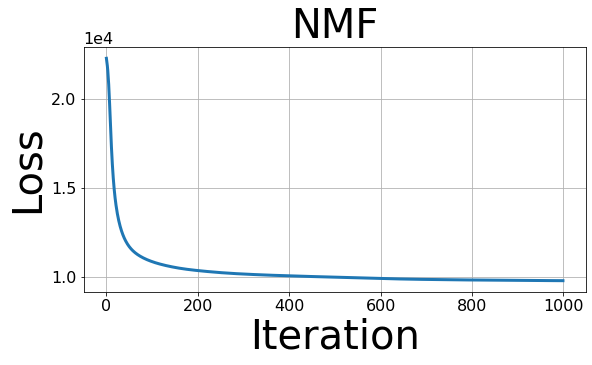

In [42]:
# Loss plot of NMF 
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

plt.figure(1, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})

plt.plot(nmf_cost[0,0:1000], linewidth=3) # show only the firt 1000 iteration to see the details

plt.xlabel('Iteration', fontsize = 40)
plt.ylabel('Loss', fontsize = 40)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30) 

plt.title('NMF', fontsize = 40)
#plt.legend(fontsize = 30)
plt.grid(True)
#plt.savefig('NMF_loss.eps', bbox_inches = 'tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


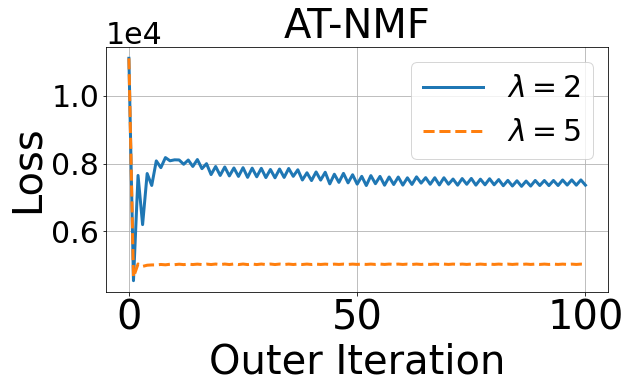

In [47]:
'''
# Plot the loss plot of AT-NMF when lambda = 2 and 5
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
#x = np.array([1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,3,4,5,6,7,8,9,10])
plt.figure(1, figsize=[9,4.5])
plt.rcParams.update({'font.size': 16})

plt.plot(anmf_cost1[0,0:], linewidth=3, label=r'$\lambda = 2$')
plt.plot(anmf_cost4[0,0:],'--', linewidth=3, label=r'$\lambda = 5$')
plt.xlabel('Outer Iteration', fontsize = 40)
plt.ylabel('Loss', fontsize = 40)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30) 

plt.title('AT-NMF', fontsize = 40)
plt.legend(fontsize = 30)
plt.grid(True)
#savefig('tex_demo')
plt.savefig('AT-NMF_loss.eps', bbox_inches = 'tight')
plt.show()
'''

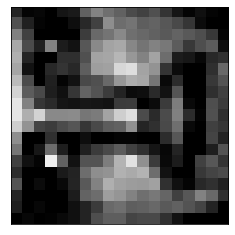

In [43]:
# Show the first image in CBCL dataset
plt.imshow( V[:,0].reshape((19,19)).cpu().numpy(), cmap='gray', vmin = 0, vmax = 1) # 0: black, 1: white

plt.yticks([])
plt.xticks([])

plt.show()

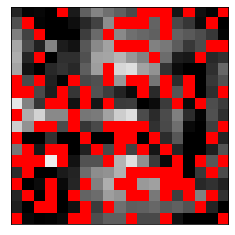

In [44]:
# Show the masked training image V, missing pixels in red
im = (D_ls *(V))[:,0].reshape((19,19)).cpu().numpy()
temp = D_ls[:,0].reshape((19,19)).cpu().numpy()
allzeros = np.transpose(np.where(temp ==0))
I = np.dstack([im, im, im])
for i in allzeros:
    I[i[0],i[1],:] = [1, 0, 0]
plt.yticks([])
plt.xticks([])
plt.imshow(I, interpolation='nearest', cmap = 'gray',vmin = 0, vmax = 1 )  
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


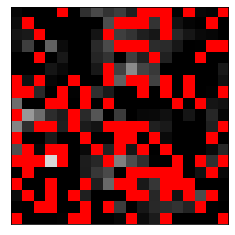

In [45]:
# Show the adversary adds-on image R*
im = (D_ls *(R_1))[:,0].reshape((19,19)).cpu().numpy()
temp = D_ls[:,0].reshape((19,19)).cpu().numpy()
allzeros = np.transpose(np.where(temp ==0))
I = np.dstack([im, im, im])
for i in allzeros:
    I[i[0],i[1],:] = [1, 0, 0]
plt.yticks([])
plt.xticks([])
plt.imshow(I, interpolation='nearest', cmap = 'gray',vmin = 0, vmax = 1 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


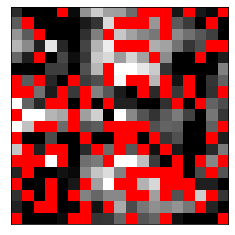

In [46]:
# Show the adversarially trained masked image V+R*
im = (D_ls *(V+R_1))[:,0].reshape((19,19)).cpu().numpy()
temp = D_ls[:,0].reshape((19,19)).cpu().numpy()
allzeros = np.transpose(np.where(temp ==0))
I = np.dstack([im, im, im])
for i in allzeros:
    I[i[0],i[1],:] = [1, 0, 0]
plt.yticks([])
plt.xticks([])
plt.imshow(I, interpolation='nearest', cmap = 'gray',vmin = 0, vmax = 1 )

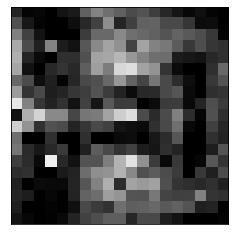

In [47]:
# Show the restore image by AT-NMF
plt.imshow((D_ls * V + (1-D_ls)*(W_at_1 @ H_at_1))[:,0].reshape((19,19)).cpu().numpy(), cmap='gray', vmin = 0, vmax = 1) # 0: black, 1: white
#plt.ylabel(r'V+R $(\lambda = 5)$')
#plt.gca().axes.get_yaxis().set_visible(False)
plt.yticks([])
plt.xticks([])
plt.show()

# Check the Basis

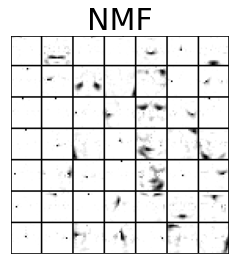

In [48]:
# Basis image trained by standard NMF
set_cmap('gray')
blank = new("L", (133 + 6, 133 + 6))
for i in range(7):
    for j in range(7):
        basis = W_nmf.cpu().numpy()[:,7*i+j].reshape((19,19))
        basis = basis / (np.max(basis)-np.min(basis)) * 255
        basis = 255 - basis
        ima = fromarray(basis)
        ima = ima.rotate(270)
        expand(ima, border=1, fill='black')
        blank.paste(ima.copy(), (j * 19 + j, i * 19 + i))
plt.title('NMF', fontsize = '30')
plt.yticks([])
plt.xticks([])
#plt.savefig('nmf_restored.eps', bbox_inches = 'tight')

imshow(blank)

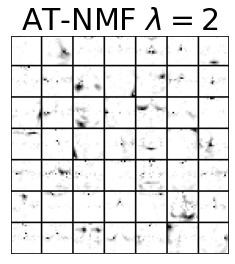

In [49]:
# Basis image trained by AT-NMF (lambda = 2)
set_cmap('gray')
blank = new("L", (133 + 6, 133 + 6))
for i in range(7):
    for j in range(7):
        basis = W_at_1.cpu().numpy()[:,7*i+j].reshape((19,19))
        basis = basis / (np.max(basis)-np.min(basis)) * 255
        basis = 255 - basis
        ima = fromarray(basis)
        ima = ima.rotate(270)
        expand(ima, border=1, fill='black')
        blank.paste(ima.copy(), (j * 19 + j, i * 19 + i))
plt.title(r'AT-NMF $\lambda = 2$', fontsize = '30')
plt.yticks([])
plt.xticks([])

imshow(blank)